# 

# Importando Bibliotecas

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
sns.set_palette("pastel")

# Carregando Dataset

In [251]:
df = pd.read_csv("Data/VendasSupermercadosCDI.csv", sep=";")
df = df.sort_values(by='Date')
df.head()

,Date,VendasSupermercados,CDI
0,2010-01-01,76.39,0.66
1,2010-02-01,73.95,0.59
2,2010-03-01,81.69,0.76
3,2010-04-01,77.91,0.66
4,2010-05-01,78.66,0.75


In [252]:
df.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 164 non-null    object 
 1   VendasSupermercados  164 non-null    float64
 2   CDI                  164 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.0+ KB


## Descrição das Features

O dataset possui três colunas 
- **Date:** Representa o mês e ano das vendas no supermercado
- **VendasSupermercados:** Vendas do supermercado naquele mês
- **CDI:** Valor do CDI (Certificado de Depósito Interbancário) naquele mês

# Engenharia de Variáveis

In [253]:
# função que converte a feature Date para datetime
def convert_date_column(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    return df

convert_date_column(df, 'Date')

# função que cria uma coluna de trimestres
def trimester_column(df, date_column):
    df['Trimestre'] = df[date_column].dt.to_period("Q")
    return df

df = trimester_column(df, 'Date')

# função que cria uma coluna de vendas por trimestre
def calculate_sales_per_trimester(df, sales_column):
    df['VendasPorTrimestre'] = df.groupby('Trimestre')[sales_column].transform('sum')
    return df

df = calculate_sales_per_trimester(df, 'VendasSupermercados')

# Cria uma coluna com os anos das vendas
def year_column(df, date_column):
    df['Ano'] = df[date_column].dt.year
    return df

df = year_column(df, 'Date')

# Calcula as vendas por ano
def calculate_sales_per_year(df, sales_column):
    df['VendasPorAno'] = df.groupby('Ano')[sales_column].transform('sum')
    return df

df = calculate_sales_per_year(df, 'VendasSupermercados')

# Calcula a taxa de vendas por valor do cdi
def sales_per_cdi_column(df, vendas_column, cdi_column):
    df['VendasPorCDI'] = df[vendas_column] / df[cdi_column]
    return df

df = sales_per_cdi_column(df, 'VendasSupermercados', 'CDI')

# função para calcular a diferença de vendas mes a mes
def calculate_sales_difference_month(df, date_column, sales_column):
    # Calculando a diferença de vendas entre um mês e o anterior
    df['DiferencaVendasMes'] = df[sales_column] - df[sales_column].shift(1)

    # Preenchendo valores NaN na coluna 'DiferencaVendas' com 0
    df['DiferencaVendasMes'] = df['DiferencaVendasMes'].fillna(0)
    
    return df

df = calculate_sales_difference_month(df, 'Date', 'VendasSupermercados')

# função para calcular a diferença de vendas trimestre a trimestre 
def calculate_sales_difference_trimester(df, date_column, sales_column):
    # Calculando a diferença de vendas entre um mês e o anterior
    df['DiferencaVendasTrimestre'] = df[sales_column] - df[sales_column].shift(1)

    # Preenchendo valores NaN na coluna 'DiferencaVendas' com 0
    df['DiferencaVendasTrimestre'] = df['DiferencaVendasTrimestre'].fillna(0)
    
    return df

df = calculate_sales_difference_trimester(df, 'Trimestre', 'VendasPorTrimestre')

# função para calcular a diferença de vendas ano a ano
def calculate_sales_difference_year(df, date_column, sales_column):
    # Calculando a diferença de vendas entre um mês e o anterior
    df['DiferencaVendasAno'] = df[sales_column] - df[sales_column].shift(1)

    # Preenchendo valores NaN na coluna 'DiferencaVendas' com 0
    df['DiferencaVendasAno'] = df['DiferencaVendasAno'].fillna(0)
    
    return df

df = calculate_sales_difference_year(df, 'Ano', 'VendasPorAno')

# função para calcular as médias móveis por trimestre
def quarterly_moving_average_column(df, date_column, sales_column):
    # Calculando a média móvel trimestral
    df['MediaMovelTrimestral'] = df[sales_column].rolling(window=3, min_periods=1).mean()
    
    return df

df = quarterly_moving_average_column(df, 'Date', 'VendasSupermercados')

# função para calcular as médias móveis por ano
def yearly_moving_average_column(df, date_column, sales_column):
    # Calculando a média móvel trimestral
    df['MediaMovelAnual'] = df[sales_column].rolling(window=12, min_periods=1).mean()
    
    return df

df = yearly_moving_average_column(df, 'Date', 'VendasSupermercados')

# função que cria uma coluna de vendas atípicas (-1 -> para vendas menores que 50% do mês anterior | 1 -> para vendas maiores que 50% do mês anterior | 0 -> para as demais)
# Função que cria uma coluna de vendas atípicas
def sales_atypical(df, sales_column):
    # Calculando a diferença de vendas entre um mês e o anterior
    df['DiferencaVendas'] = df[sales_column] / df[sales_column].shift(1)
    
    # Criando a coluna de vendas atípicas
    df['VendasAtipicas'] = 0
    df.loc[df['DiferencaVendas'] > 1.15, 'VendasAtipicas'] = 1

    # Removendo a coluna de diferença de vendas
    df = df.drop('DiferencaVendas', axis=1)
    
    return df

df = sales_atypical(df, 'VendasSupermercados')

df.head()

,Date,VendasSupermercados,CDI,Trimestre,VendasPorTrimestre,Ano,VendasPorAno,VendasPorCDI,DiferencaVendasMes,DiferencaVendasTrimestre,DiferencaVendasAno,MediaMovelTrimestral,MediaMovelAnual,VendasAtipicas
0,2010-01-01,76.39,0.66,2010Q1,232.03,2010,970.47,115.742424,0.00,0.00,0.0,76.390000,76.390000,0
1,2010-02-01,73.95,0.59,2010Q1,232.03,2010,970.47,125.338983,-2.44,0.00,0.0,75.170000,75.170000,0
2,2010-03-01,81.69,0.76,2010Q1,232.03,2010,970.47,107.486842,7.74,0.00,0.0,77.343333,77.343333,0
3,2010-04-01,77.91,0.66,2010Q2,233.47,2010,970.47,118.045455,-3.78,1.44,0.0,77.850000,77.485000,0
4,2010-05-01,78.66,0.75,2010Q2,233.47,2010,970.47,104.880000,0.75,0.00,0.0,79.420000,77.720000,0


In [254]:
print(df.Date.max())
print(df.Date.min())

2023-08-01 00:00:00
2010-01-01 00:00:00


Vemos que o intervalo entre a primeira e a última data de vendas do dataset é de aproximadamente 13 anos e meio. Além disso, devemos nos atentar para o fato da série temporal de 2023 está incompleta o que afeta a análise

In [255]:
df_train = df[df['Date'] < '2023-04-01']
df_test = df[(df['Date'] < '2023-07-01') & (df['Date'] > '2023-03-01')]
print(df_train.Date.max())
print(df_train.Date.min())
print(df_test.Date.max())
print(df_test.Date.min())


2023-03-01 00:00:00
2010-01-01 00:00:00
2023-06-01 00:00:00
2023-04-01 00:00:00


Dividindo os dados logo no ínicio da análise para evitar vazamento e simular o ambiente real

# Análise Exploratória de Dados

In [256]:
df_train.columns

Index(['Date', 'VendasSupermercados', 'CDI', 'Trimestre', 'VendasPorTrimestre',
       'Ano', 'VendasPorAno', 'VendasPorCDI', 'DiferencaVendasMes',
       'DiferencaVendasTrimestre', 'DiferencaVendasAno',
       'MediaMovelTrimestral', 'MediaMovelAnual', 'VendasAtipicas'],
      dtype='object')

In [257]:
# Analisando as dimensões do dataset
df.shape

(164, 14)

O dataset possui poucas linhas e colunas, então buscaremos criar mais variáveis para melhorar o modelo final

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      164 non-null    datetime64[ns]
 1   VendasSupermercados       164 non-null    float64       
 2   CDI                       164 non-null    float64       
 3   Trimestre                 164 non-null    period[Q-DEC] 
 4   VendasPorTrimestre        164 non-null    float64       
 5   Ano                       164 non-null    int32         
 6   VendasPorAno              164 non-null    float64       
 7   VendasPorCDI              164 non-null    float64       
 8   DiferencaVendasMes        164 non-null    float64       
 9   DiferencaVendasTrimestre  164 non-null    float64       
 10  DiferencaVendasAno        164 non-null    float64       
 11  MediaMovelTrimestral      164 non-null    float64       
 12  MediaMovelAnual       

As features não possuem valores ausentes. As **VendasSupermercados** e **CDI** estão num formato correto, porém a **Date** precisar ser transformado para datetime

In [259]:
df.describe()

,Date,VendasSupermercados,CDI,VendasPorTrimestre,Ano,VendasPorAno,VendasPorCDI,DiferencaVendasMes,DiferencaVendasTrimestre,DiferencaVendasAno,MediaMovelTrimestral,MediaMovelAnual,VendasAtipicas
count,164,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,2016-10-15 19:19:01.463414528,93.174329,0.738537,278.254085,2016.341463,1098.547317,167.135756,0.172927,-0.145915,-1.031341,93.001768,92.340586,0.079268
min,2010-01-01 00:00:00,73.950000,0.130000,208.100000,2010.000000,801.330000,72.017241,-26.170000,-93.810000,-398.660000,75.170000,75.170000,0.000000
25%,2013-05-24 06:00:00,88.070000,0.537500,265.607500,2013.000000,1071.680000,94.318651,-3.720000,0.000000,0.000000,88.458333,89.544375,0.000000
50%,2016-10-16 12:00:00,91.700000,0.785000,276.460000,2016.000000,1120.310000,116.249590,-0.055000,0.000000,0.000000,92.748333,93.407917,0.000000
75%,2020-03-08 18:00:00,97.612500,0.952500,296.820000,2020.000000,1143.540000,176.345486,4.520000,0.000000,0.000000,98.602500,96.403542,0.000000
max,2023-08-01 00:00:00,122.750000,1.210000,327.600000,2023.000000,1211.920000,747.625000,22.640000,33.900000,90.090000,109.200000,102.220000,1.000000
std,NaN,9.001255,0.281626,23.128121,3.960602,93.788564,133.404225,9.516630,14.003016,33.163154,7.104352,6.343148,0.270984


Vemos que a média e mediana das **VendasSupermercados** estão próximas, isso pode indicar uma distribuição mais simétrica dos dados e provavelmente pouca presença de outliers. Além disso, o desvio padrão do **CDI** está em quase 40% da média do **CDI** o que indica uma variabilidade considerável

In [260]:
df.nunique(axis=0)

Date                        164
VendasSupermercados         152
CDI                          75
Trimestre                    55
VendasPorTrimestre           54
Ano                          14
VendasPorAno                 14
VendasPorCDI                164
DiferencaVendasMes          159
DiferencaVendasTrimestre     53
DiferencaVendasAno           14
MediaMovelTrimestral        162
MediaMovelAnual             164
VendasAtipicas                2
dtype: int64

Percebemos que não há datas repitidas, porém alguns dias com o mesmo número de vendas da mesma forma do CDI

In [261]:
df.VendasSupermercados.value_counts()

VendasSupermercados
87.41     2
97.68     2
94.48     2
89.43     2
84.39     2
         ..
92.38     1
89.01     1
116.78    1
96.75     1
104.75    1
Name: count, Length: 152, dtype: int64

In [262]:
df.CDI.value_counts()

CDI
0.54    8
1.11    6
0.86    6
0.84    5
1.07    5
       ..
1.00    1
1.21    1
1.08    1
0.50    1
1.14    1
Name: count, Length: 75, dtype: int64

isso confirma o que falamos acima e vemos quais os valores com repeticões e quais os mais repitidos

In [263]:
df.VendasAtipicas.value_counts()

VendasAtipicas
0    151
1     13
Name: count, dtype: int64

In [264]:
df.duplicated().sum()

0

Não temos nenhuma linha duplicada

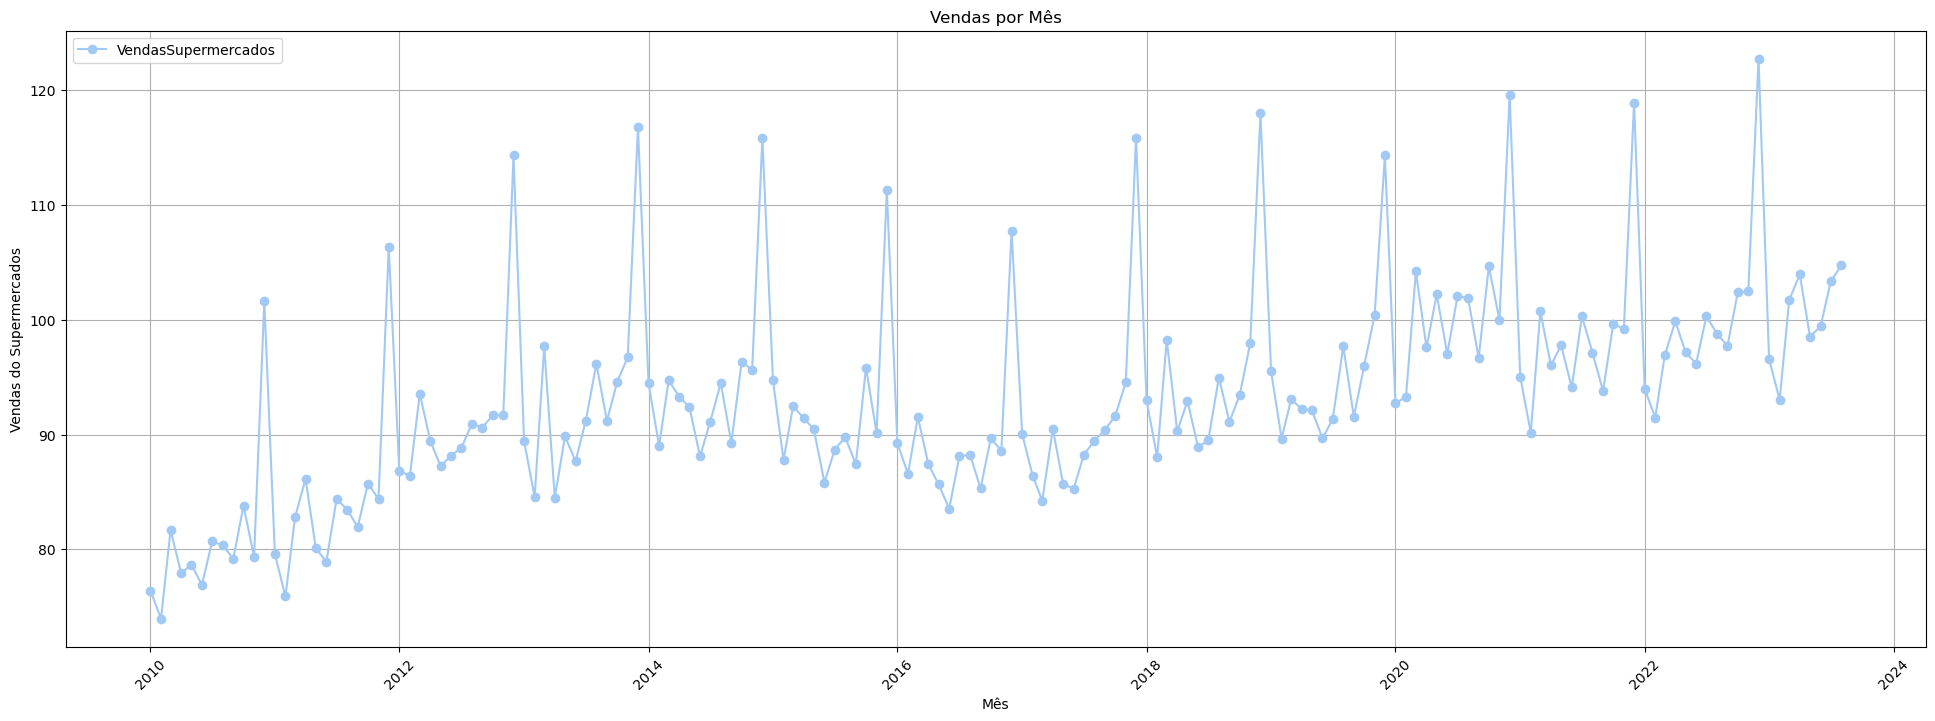

In [265]:
plt.figure(figsize=(24, 8))
plt.plot(df['Date'], df['VendasSupermercados'], label='VendasSupermercados', marker='o')
plt.title('Vendas por Mês')
plt.xlabel('Mês')
plt.ylabel('Vendas do Supermercados')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Vemos que em dezembro é quando ocorrem o maior nímero de vendas e isso se repete ano a ano

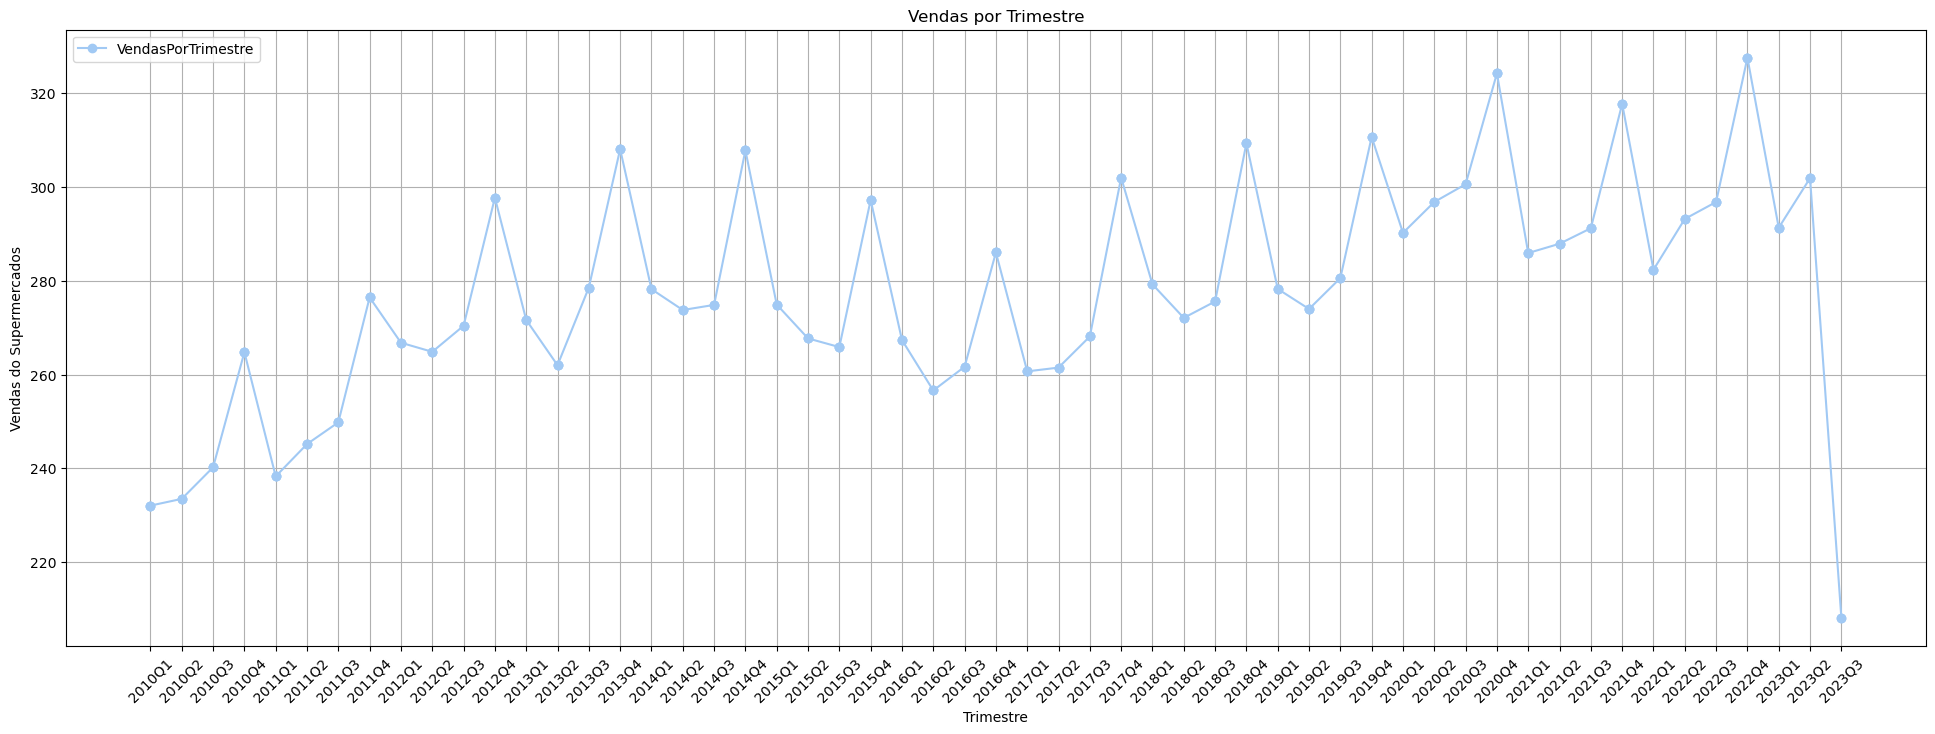

In [266]:
ax = df.copy()
ax['Trimestre'] = ax['Trimestre'].astype(str)

plt.figure(figsize=(24, 8))
plt.plot(ax['Trimestre'], ax['VendasPorTrimestre'], label='VendasPorTrimestre', marker='o')
plt.title('Vendas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Vendas do Supermercados')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

O gráfico acima mostra uma tendência no cresimento das vendas do começo ao final de cada ano, com um crescimeto mais acentuado no último trimestre do ano, provavelmente devido as festas de final de ano e black friday, além disso, a queda abrupta no 3° trimestre de 2023 se deve ao fato de não contemplar as vendas de todo o período

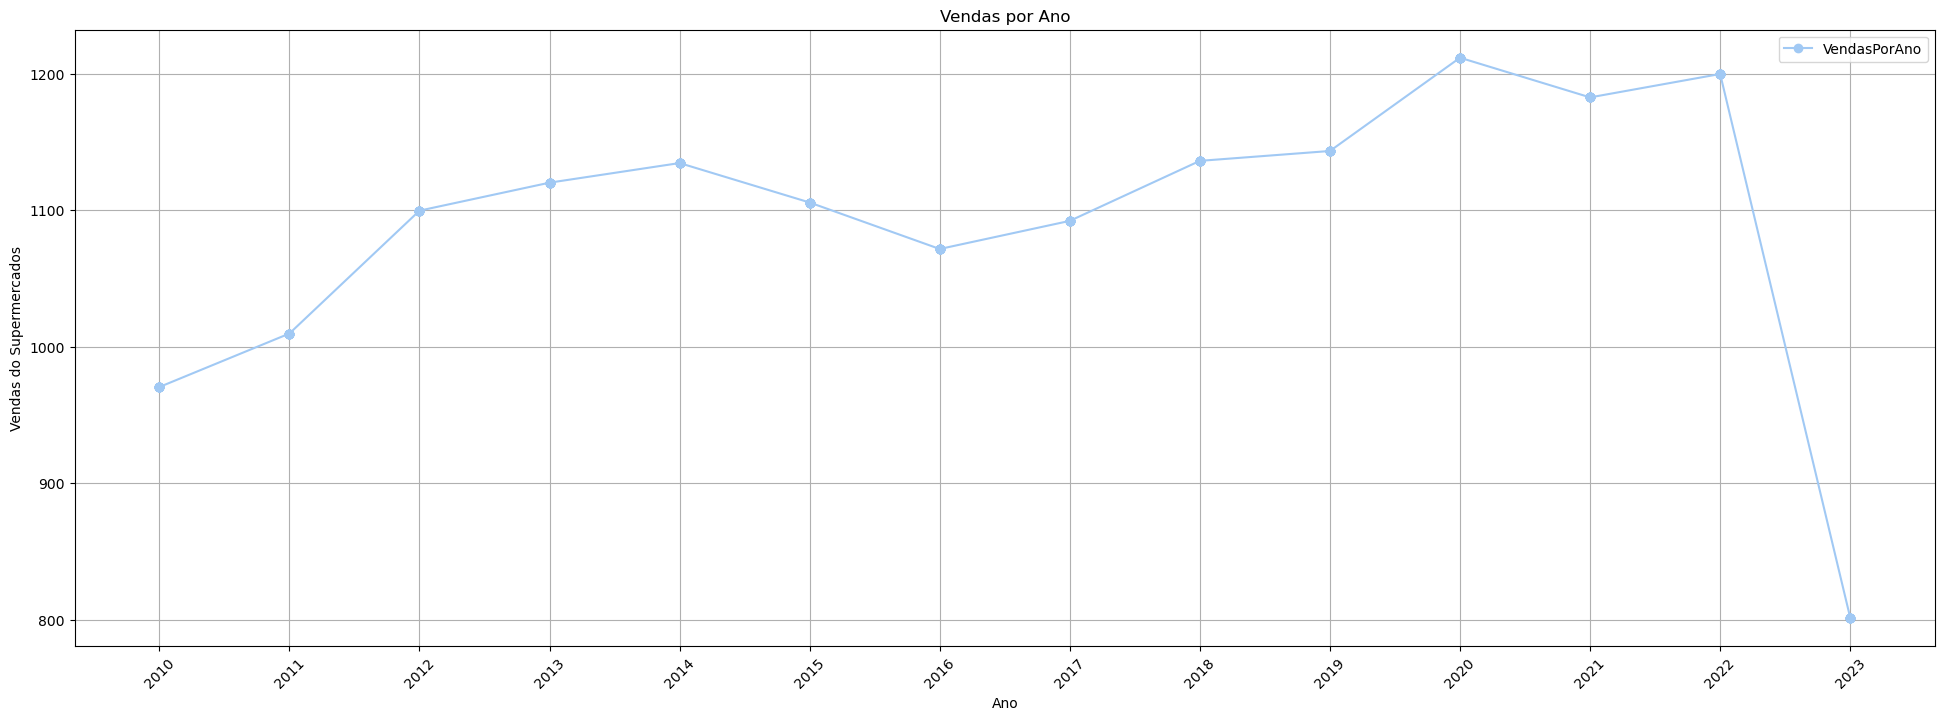

In [267]:
ax = df.copy()
ax['Ano'] = ax['Ano'].astype(str)
plt.figure(figsize=(24, 8))
plt.plot(ax['Ano'], ax['VendasPorAno'], label='VendasPorAno', marker='o')
plt.title('Vendas por Ano')
plt.xlabel('Ano')
plt.ylabel('Vendas do Supermercados')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

o gráfico mostra uma leve tendência de crescimento de vendas ao longo dos anos, porém de forma oscilante

O CDI não segue uma tendência clara ao longo do tempo

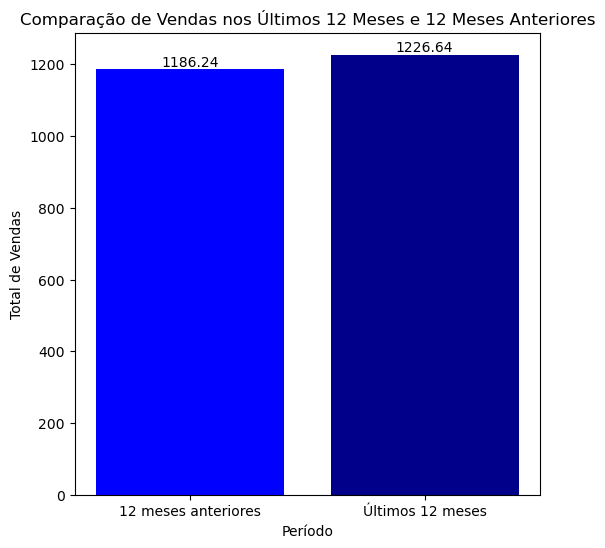

O aumento de vendas dos últimos 12 meses em comparação aos 12 meses anteriores foi de 3.41%.


In [268]:
# Selecionando os últimos 12 meses 
last_12_months = df[(df['Date'] >= '2022-09-01') & (df['Date'] <= '2023-08-31')]

# selecionando os 12 meses anteriores
previous_12_months = df[(df['Date'] >= '2021-09-01') & (df['Date'] <= '2022-08-31')]

# calculando o total de vendas nos últimos 12 meses
sales_last_12_months = last_12_months['VendasSupermercados'].sum()

# calculando as vendas nos 12 meses anteriores
sales_previous_12_months = previous_12_months['VendasSupermercados'].sum()

months = ['12 meses anteriores', 'Últimos 12 meses']
sales = [sales_previous_12_months, sales_last_12_months]

plt.figure(figsize=(6,6))
plt.bar(months, sales, color=['blue', 'darkblue'])
plt.title('Comparação de Vendas nos Últimos 12 Meses e 12 Meses Anteriores')
plt.xlabel('Período')
plt.ylabel('Total de Vendas')
for i, value in enumerate(sales):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()


# Calculando a porcentagem do crescimento de vendas dos últimos 12 meses em comparação aos 12 meses anteriores
sales_increase_percentage = ((sales_last_12_months / sales_previous_12_months) -1) * 100

print(f'O aumento de vendas dos últimos 12 meses em comparação aos 12 meses anteriores foi de {sales_increase_percentage:.2f}%.')

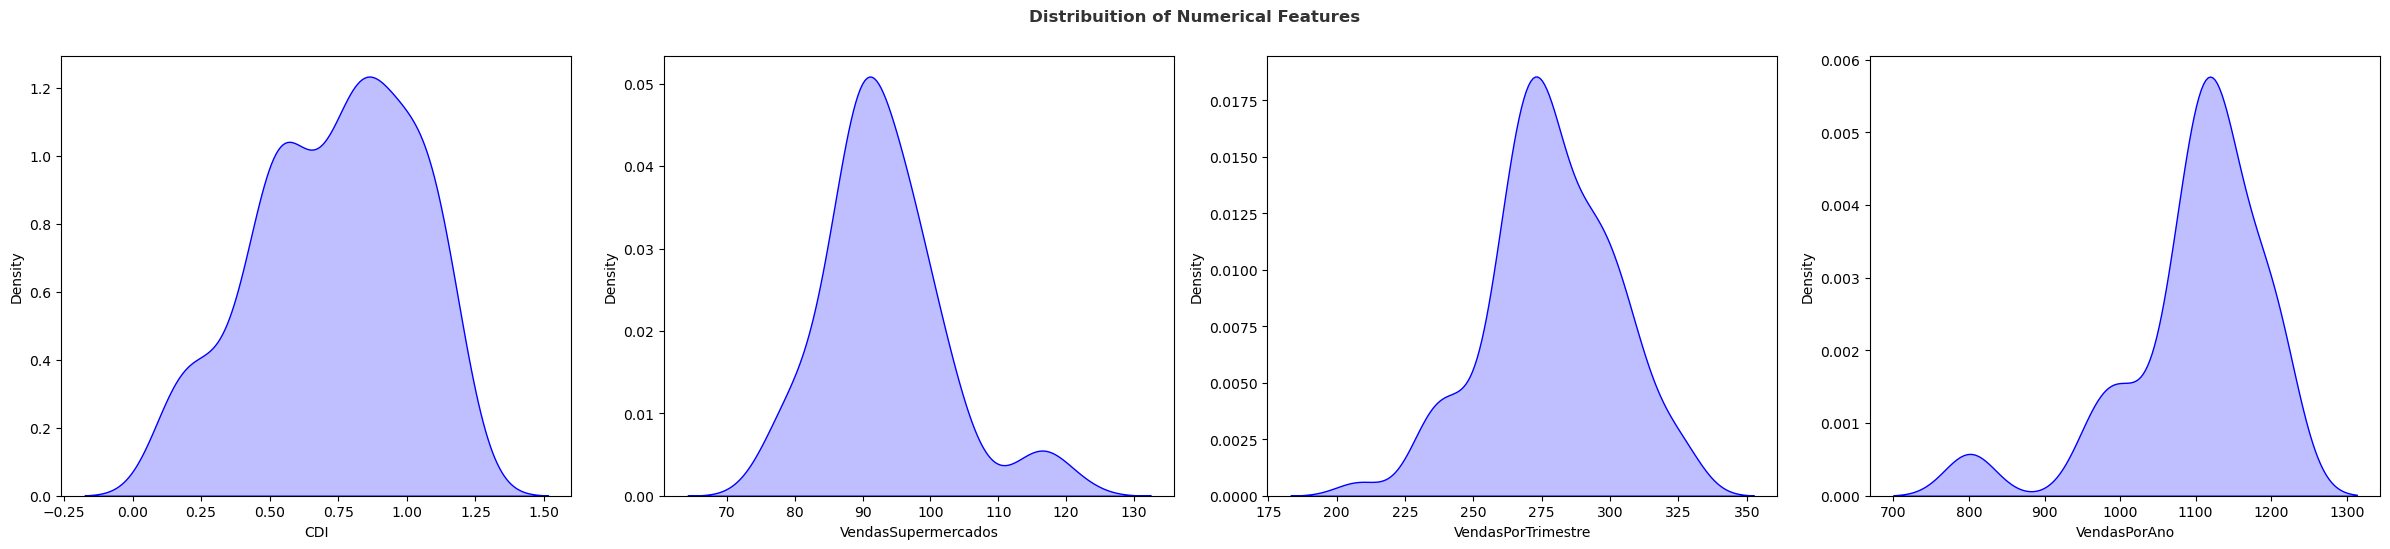

In [269]:
numerical_features = ['CDI', 'VendasSupermercados', 'VendasPorTrimestre', 'VendasPorAno']

plt.figure(figsize=(24, 10))
plt.suptitle('Distribuition of Numerical Features', fontsize=12, fontweight='bold', alpha=0.8, y=1.)
for i in range(len(numerical_features)):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(x=df[numerical_features[i]], shade=True, color='b')
    plt.xlabel(numerical_features[i])
    plt.tight_layout()

As distribuições de vendas por trimestre é levemente melhor distribuída que as demais 

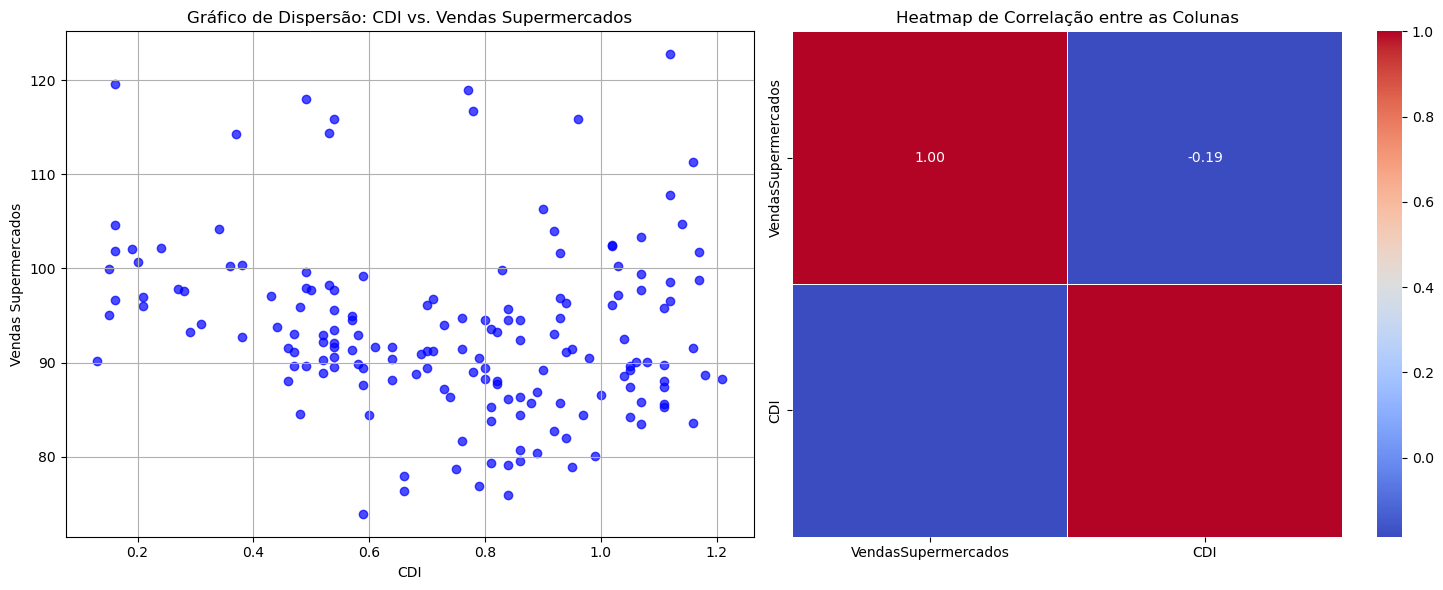

In [270]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de Dispersão
axs[0].scatter(df['CDI'], df['VendasSupermercados'], color='blue', alpha=0.7)
axs[0].set_title('Gráfico de Dispersão: CDI vs. Vendas Supermercados')
axs[0].set_xlabel('CDI')
axs[0].set_ylabel('Vendas Supermercados')
axs[0].grid(True)

# Heatmap
correlation_matrix = df[['VendasSupermercados', 'CDI']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, ax=axs[1])
axs[1].set_title('Heatmap de Correlação entre as Colunas')

plt.tight_layout()
plt.show()

A correlação entre as vendas e o valor do DCI no período é baixa o que indica que provavelmente o valor do CDI não impacta diretamente nas vendas, o gráfico de dispersão reforça isso também, pois o gráfico está bem disperso 

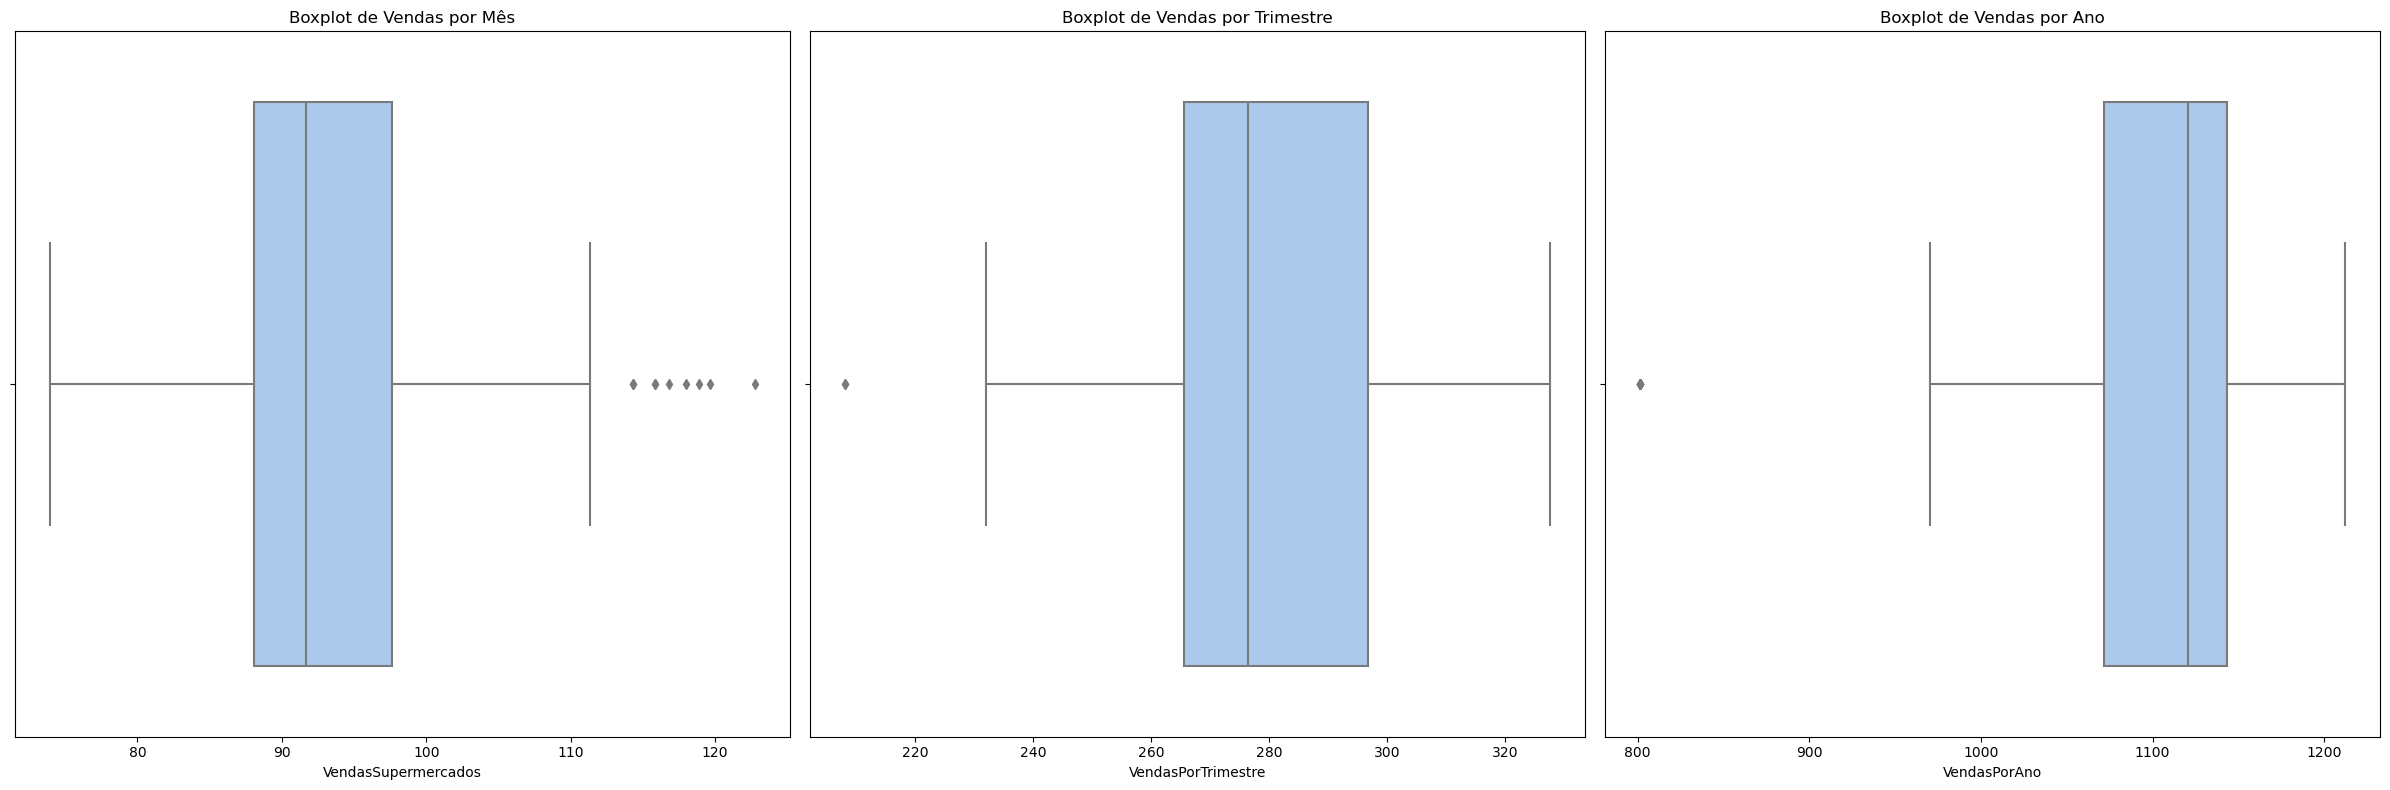

In [271]:
plt.figure(figsize=(24, 8))

# Boxplot por mês
plt.subplot(1, 3, 1)
sns.boxplot(x='VendasSupermercados', data=df, palette='pastel')
plt.title('Boxplot de Vendas por Mês')

# Boxplot por trimestre
plt.subplot(1, 3, 2)
sns.boxplot(x='VendasPorTrimestre', data=df, palette='pastel')
plt.title('Boxplot de Vendas por Trimestre')

# Boxplot por ano
plt.subplot(1, 3, 3)
sns.boxplot(x='VendasPorAno', data=df, palette='pastel')
plt.title('Boxplot de Vendas por Ano')

plt.tight_layout()
plt.show()

Vemos que quando analisamos as vendas em um período menor, como meses, temos as presenças de vários outiliers nas vendas que são as vendas em dezembro, quanto maior o período analisado vemos que não possuímos mais outiliers (vendas discrepantes)  
Obs: Note que os outiliers nos gráficos de vendas por trimestre e por ano são devido a um peírodo não completo

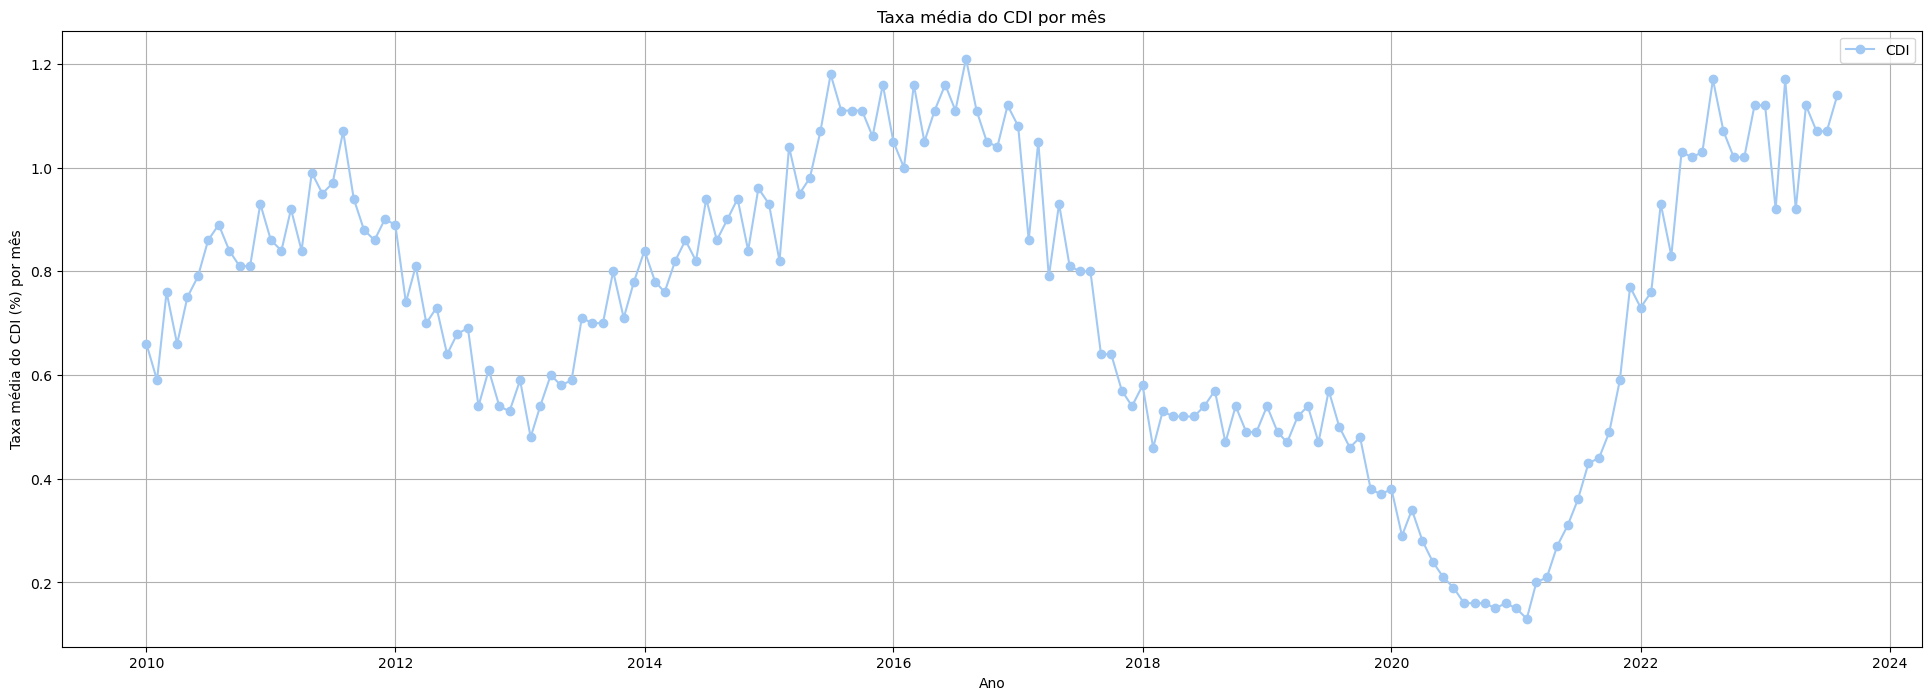

In [272]:
plt.figure(figsize=(24, 8))
plt.plot(df['Date'], df['CDI'], label='CDI', marker='o')
plt.title('Taxa média do CDI por mês')
plt.xlabel('Ano')
plt.ylabel('Taxa média do CDI (%) por mês')
plt.legend()
plt.grid(True)
plt.show()

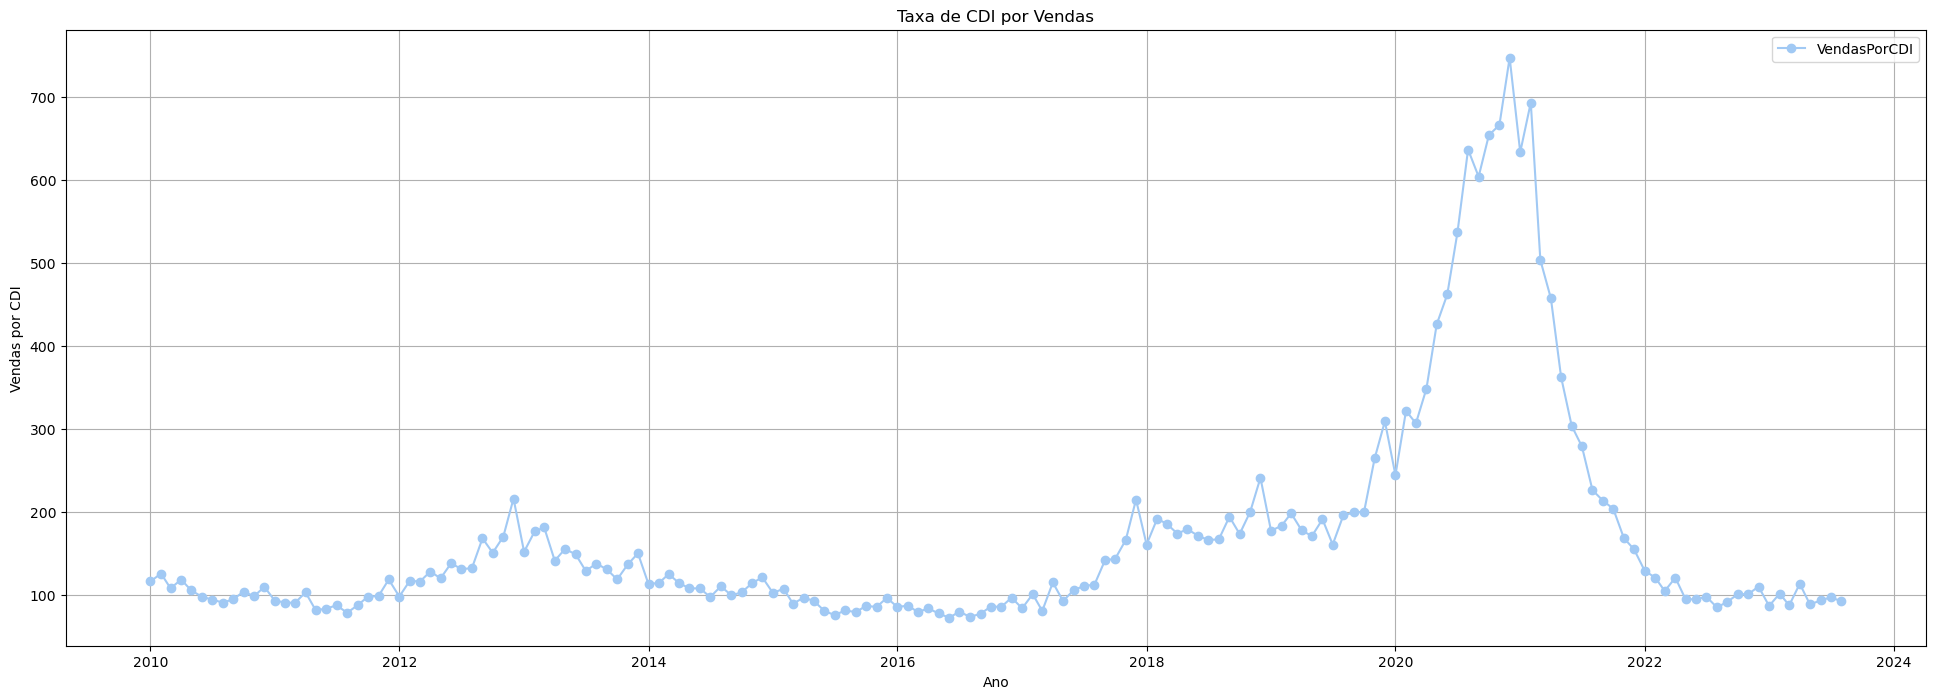

In [273]:
plt.figure(figsize=(24, 8))
plt.plot(df['Date'], df['VendasPorCDI'], label='VendasPorCDI', marker='o')
plt.title('Taxa de CDI por Vendas')
plt.xlabel('Ano')
plt.ylabel('Vendas por CDI')
plt.legend()
plt.grid(True)
plt.show()

Vemos que entre os anos de 2020 e 2022 há uma alta taxa de vendas por CDI que se diferem muito dos anos anteriores, uma hipótese seria que durante o período de pandemia a taxa de CDI diminuiu bastante, o que vemos no gráfico acima do CDI ao longo do tempo e as vendas mantiveram uma tendência de leve aumento

In [274]:
# Função para realizar o teste de Dickey-Fuller
def adf_test(time_series):
    result = adfuller(time_series, autolag='AIC')

    print('Teste Estatístico:', result[0])
    print('Valor-P:', result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    print('\nResultado do Teste:')
    if result[1] <= 0.05:
        print("Rejeitar a hipótese nula. A série é estacionária.")
    else:
        print("Falha em rejeitar a hipótese nula. A série não é estacionária.")

# Aplicando o teste de Dickey-Fuller na série temporal
adf_test(df['VendasPorTrimestre'])

Teste Estatístico: -2.357815942775721
Valor-P: 0.15399809731169822
Valores Críticos:
   1%: -3.4744158894942156
   5%: -2.880878382771059
   10%: -2.577081275821236

Resultado do Teste:
Falha em rejeitar a hipótese nula. A série não é estacionária.


Como nossa série é não estacionária, então faremos uma transformação daos para torná-la estacionária para facilitar a modelagem

# Modelo

### Modelo de Regressão Linear (Baseline)